In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import statistics # For median


In [39]:
directory = './pckl/'
file_names = [
    "gls_run_pop6_iter_count_10000_20250329_225746.pkl",
    "gls_run_pop10_iter_count_10000_20250329_233150.pkl",
    "gls_run_pop20_iter_count_10000_20250330_004003.pkl",
    "gls_run_pop50_iter_count_10000_20250330_043145.pkl",
    "gls_run_pop100_iter_count_10000_20250330_101647.pkl"
]

In [40]:
data = {}
for file_name in file_names:
    path = os.path.join(directory, file_name)
    with open(path, 'rb') as f:
        data[file_name] = pickle.load(f)


In [41]:
for name, obj in data.items():
    print(f"{name}: {type(obj)}")
    print(f"  {obj}")

gls_run_pop6_iter_count_10000_20250329_225746.pkl: <class 'dict'>
  {'pop_size': 6, 'max_iterations': 10000, 'best_cut_size': 16, 'time_elapsed': 1242.8891468048096, 'average_best_by_iteration': 16.0211, 'iteration_log': [{'iteration': 1, 'best_cut_size_so_far': 48, 'best_cut_size_this_iter': 48}, {'iteration': 2, 'best_cut_size_so_far': 38, 'best_cut_size_this_iter': 38}, {'iteration': 3, 'best_cut_size_so_far': 38, 'best_cut_size_this_iter': 49}, {'iteration': 4, 'best_cut_size_so_far': 32, 'best_cut_size_this_iter': 32}, {'iteration': 5, 'best_cut_size_so_far': 32, 'best_cut_size_this_iter': 32}, {'iteration': 6, 'best_cut_size_so_far': 32, 'best_cut_size_this_iter': 35}, {'iteration': 7, 'best_cut_size_so_far': 32, 'best_cut_size_this_iter': 33}, {'iteration': 8, 'best_cut_size_so_far': 23, 'best_cut_size_this_iter': 23}, {'iteration': 9, 'best_cut_size_so_far': 23, 'best_cut_size_this_iter': 25}, {'iteration': 10, 'best_cut_size_so_far': 23, 'best_cut_size_this_iter': 35}, {'itera

In [42]:
for name, obj in data.items():
    for ob in obj.keys():
        print(f"{ob}")
    break 

pop_size
max_iterations
best_cut_size
time_elapsed
average_best_by_iteration
iteration_log
timestamp


In [43]:
# Put  metrics into a dataframe 
records = []
detailed_iteration_data = {} # To store iteration logs for convergence plots

for name, obj in data.items():

    record = {
        "pop_size": obj['pop_size'],
        "max_iterations": obj['max_iterations'],
        "best_cut_size": obj['best_cut_size'],
        "time_elapsed": obj['time_elapsed'],
        "avg_best_per_iter_reported": obj.get('average_best_by_iteration', np.nan), # Use .get() for potentially missing keys
    }


# calculate additional stats
    iteration_log = obj['iteration_log']
    best_so_far = [log['best_cut_size_so_far'] for log in iteration_log]
    best_this_iter = [log['best_cut_size_this_iter'] for log in iteration_log]

    record["mean_best_this_iter"] = np.mean(best_this_iter)
    record["std_dev_best_this_iter"] = np.std(best_this_iter)
    record["min_best_this_iter"] = np.min(best_this_iter)
    record["max_best_this_iter"] = np.max(best_this_iter)

    # Find iteration where the final best_cut_size was first achieved so we can now how much compute we wasted  
    final_best_size = record["best_cut_size"]
    first_achieved_iter = np.nan
    
    # Find the first index where best_so_far <= final_best_size
    first_index = next(i for i, val in enumerate(best_so_far) if val <= final_best_size)
    # Get the corresponding iteration number
    first_achieved_iter = iteration_log[first_index]['iteration']

    record["convergence_iteration"] = first_achieved_iter
    records.append(record)

    # convergence plot data    
    
    detailed_iteration_data[int(record["pop_size"])] = pd.DataFrame(iteration_log).set_index('iteration')
    

# Create DataFrame and sort
df = pd.DataFrame(records)
df = df.sort_values(by="pop_size").reset_index(drop=True)


display(df)

pop_size  max_iterations  best_cut_size  time_elapsed  \
0         6           10000             16   1242.889147   
1        10           10000             16   2043.681065   
2        20           10000             18   4093.327633   
3        50           10000              8  10302.390227   
4       100           10000             10  20701.171019   

   avg_best_per_iter_reported  mean_best_this_iter  std_dev_best_this_iter  \
0                     16.0211              16.0257                0.690246   
1                     16.0194              16.0231                0.621584   
2                     18.0831              18.0891                0.634950   
3                      8.0365               8.0390                0.854213   
4                     10.0275              10.0340                0.678265   

   min_best_this_iter  max_best_this_iter  convergence_iteration  
0                  16                  49                     21  
1                  16                  41                     16  
2                  18                  43                    349  
3                   8                  37                     29  
4                  10                  40                     48

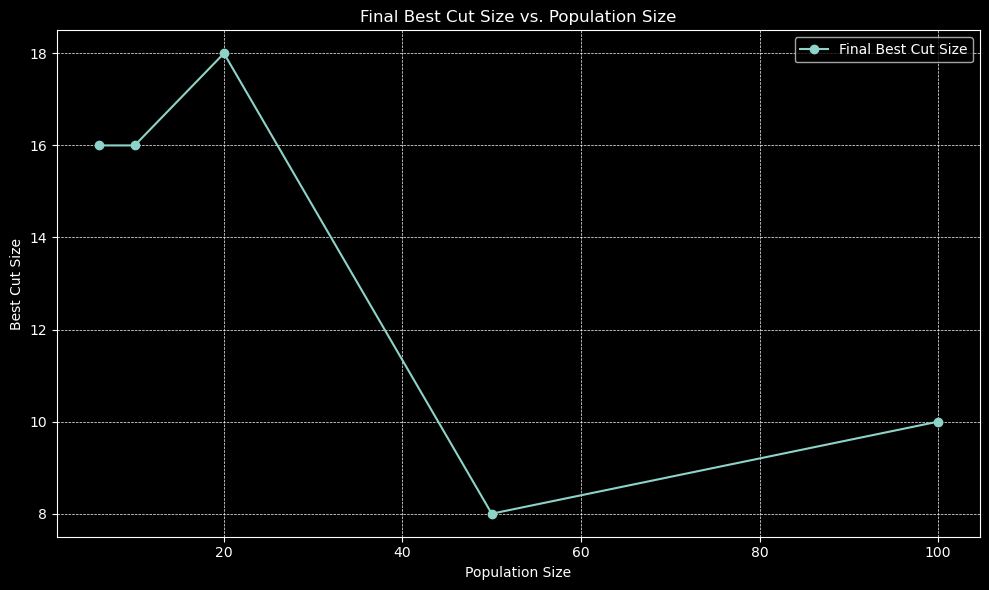

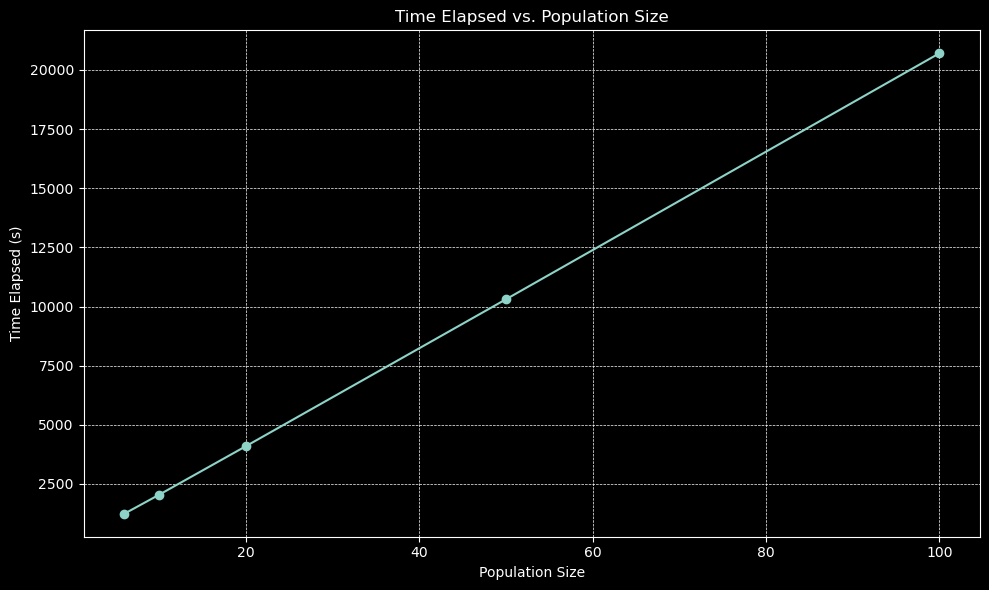

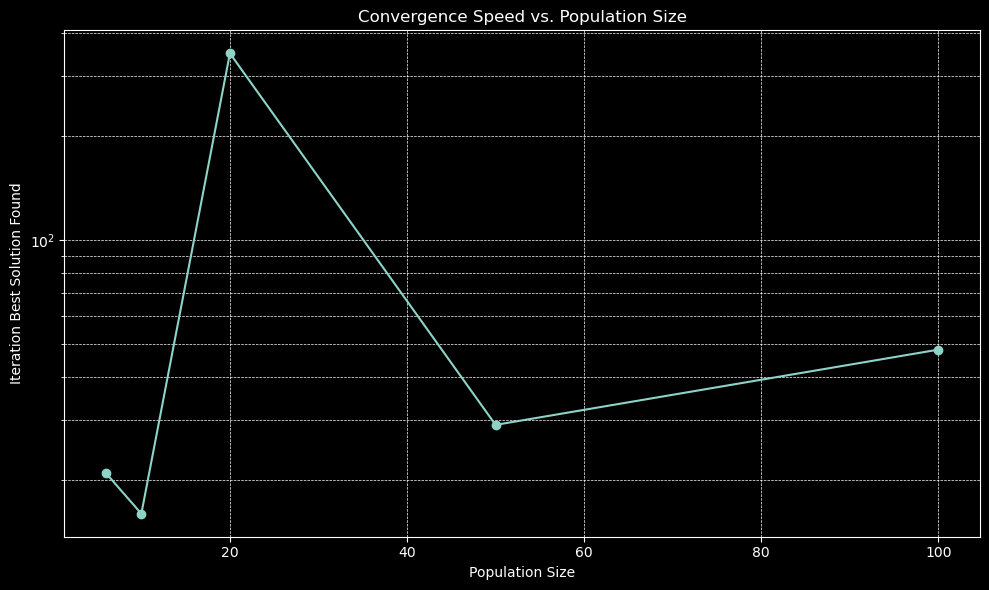

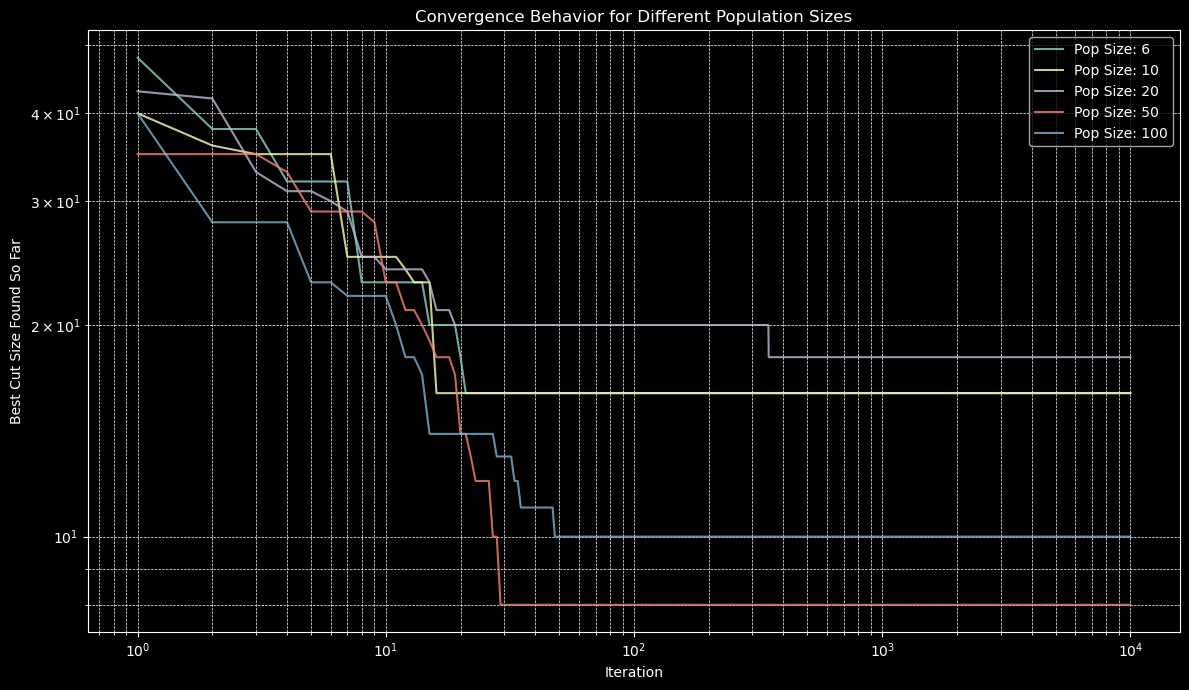

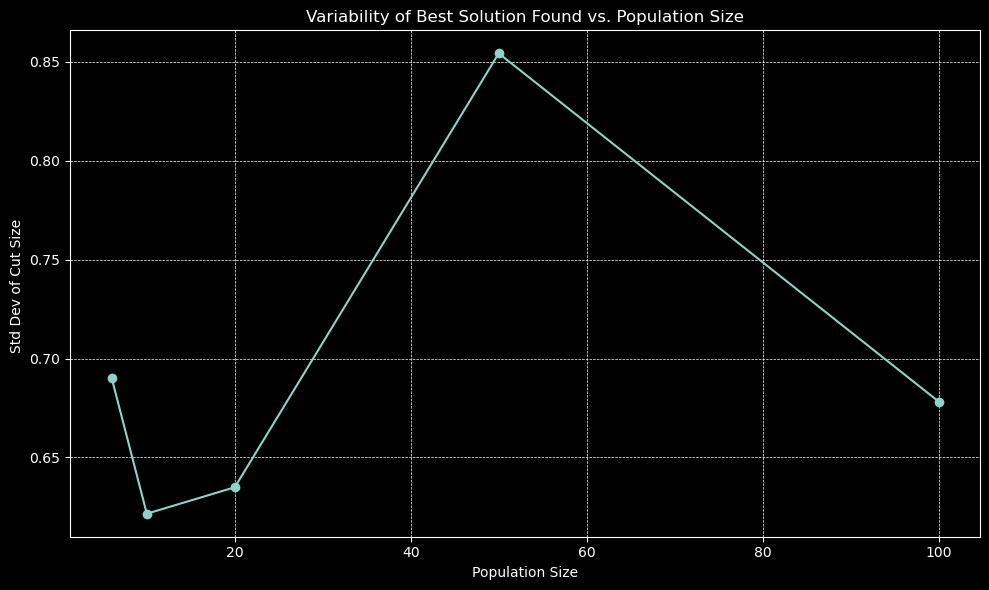

In [ ]:

# Plot 1 Best Cut Size vs. Population Size
plt.figure(figsize=(10, 6))
plt.plot(df["pop_size"], df["best_cut_size"], marker='o', linestyle='-', label='Final Best Cut Size')
#plt.plot(df["pop_size"], df["mean_best_this_iter"], marker='x', linestyle='--', label='Mean Cut Size (per iter)')

plt.xlabel("Population Size")
plt.ylabel("Best Cut Size")
plt.title("Final Best Cut Size vs. Population Size")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 2 Time Elapsed vs. Population Size
plt.figure(figsize=(10, 6))
plt.plot(df["pop_size"], df["time_elapsed"], marker='o', linestyle='-')
plt.xlabel("Population Size")
plt.ylabel("Time Elapsed (s)")
plt.title("Time Elapsed vs. Population Size")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 3 Convergence Iteration vs Population Size
plt.figure(figsize=(10, 6))
plt.plot(df["pop_size"], df["convergence_iteration"], marker='o', linestyle='-')
plt.xlabel("Population Size")
plt.ylabel("Iteration Best Solution Found")
plt.title("Convergence Speed vs. Population Size")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log') 
plt.tight_layout()
plt.show()


# Plot 4 Convergence Curves (Best Cut Size So Far vs. Iteration)
plt.figure(figsize=(12, 7))
for pop_size in sorted(detailed_iteration_data.keys()):
    iter_df = detailed_iteration_data[pop_size]
    if 'best_cut_size_so_far' in iter_df.columns:
        plt.plot(iter_df.index, iter_df['best_cut_size_so_far'], label=f'Pop Size: {pop_size}', alpha=0.8)

plt.xlabel("Iteration(log scale)")
plt.ylabel("Best Cut Size Found So Far (log scale)")
plt.title("Convergence Behavior for Different Population Sizes (log scale)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 5: Variability within runs (Std Dev of Best Cut Size This  vs Pop Size)

plt.figure(figsize=(10, 6))
plt.plot(df["pop_size"], df["std_dev_best_this_iter"], marker='o', linestyle='-')
plt.xlabel("Population Size")
plt.ylabel("Std Dev of Cut Size ")
plt.title("Variability of Best Solution Found vs. Population Size")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



In [52]:

LOAD_DIR = './pckl/SSGLS/'
file_names_to_load = [
    "gls_pop6_iter_count_1000_runs10_20250330_194243.pkl",
    "gls_pop10_iter_count_1000_runs10_20250330_195603.pkl",
    "gls_pop20_iter_count_1000_runs10_20250330_200901.pkl",
    "gls_pop50_iter_count_1000_runs10_20250330_202225.pkl",
    "gls_pop100_iter_count_1000_runs10_20250330_203634.pkl"
]


aggregated_results = [] 
convergence_logs_median_run = {}

for file_name in file_names_to_load:
    filepath = os.path.join(LOAD_DIR, file_name)
    #print(f"Processing file: {file_name}")


    with open(filepath, 'rb') as f:
        list_of_run_stats = pickle.load(f)

   

    num_runs_in_file = len(list_of_run_stats)
    #print(f"  Loaded data for {num_runs_in_file} runs.")

    # Extract basic info
    pop_size = list_of_run_stats[0].get('pop_size', np.nan)
    max_iterations = list_of_run_stats[0].get('max_iterations', np.nan)

    # Collect metrics from each run into lists
    best_cuts = [run.get('best_cut_size', np.nan) for run in list_of_run_stats]
    times = [run.get('time_elapsed', np.nan) for run in list_of_run_stats]
    convergence_iters = []

    # Recalculate convergence iteration for each run
    for i, run_stat in enumerate(list_of_run_stats):
        iter_log = run_stat.get('iteration_log', [])
        final_best_size_run = run_stat.get('best_cut_size', np.nan)
        first_achieved_iter_run = np.nan # Default for this run

        if iter_log and not np.isnan(final_best_size_run):
                best_so_far_run = [log.get('best_cut_size_so_far', np.nan) for log in iter_log]
                
                first_index = next(idx for idx, val in enumerate(best_so_far_run) if not np.isnan(val) and val <= final_best_size_run)
                first_achieved_iter_run = iter_log[first_index].get('iteration', first_index + 1)
            
        convergence_iters.append(first_achieved_iter_run)


    # calculate stat
    valid_cuts = [c for c in best_cuts if not np.isnan(c)]
    valid_times = [t for t in times if not np.isnan(t)]
    valid_conv_iters = [i for i in convergence_iters if not np.isnan(i)]

    mean_best_cut = np.mean(valid_cuts) if valid_cuts else np.nan
    std_best_cut = np.std(valid_cuts) if valid_cuts else np.nan
    mean_time = np.mean(valid_times) if valid_times else np.nan
    std_time = np.std(valid_times) if valid_times else np.nan
    mean_conv_iter = np.mean(valid_conv_iters) if valid_conv_iters else np.nan
    std_conv_iter = np.std(valid_conv_iters) if valid_conv_iters else np.nan

    # --- Find the run with the median best_cut_size ---
    median_run_log_df = pd.DataFrame() 
    if valid_cuts:
        median_cut = np.median(valid_cuts)
        # Find the index of the run closest to the median cut size
        median_run_index = np.argmin([abs(c - median_cut) if not np.isnan(c) else np.inf for c in best_cuts])
        median_run_data = list_of_run_stats[median_run_index]
        median_log = median_run_data.get('iteration_log', [])

        
        if median_log and isinstance(median_log, list) and 'iteration' in median_log[0]:                
            median_run_log_df = pd.DataFrame(median_log).set_index('iteration')
               
    min_best_cut = np.min(valid_cuts) if valid_cuts else np.nan
    max_best_cut = np.max(valid_cuts) if valid_cuts else np.nan

    convergence_logs_median_run[pop_size] = median_run_log_df
    print(f"Pop Size: {pop_size}, Median Best Cut: {median_cut}, Run Index: {median_run_index}")
    aggregated_results.append({
        "pop_size": pop_size,
        "max_iterations": max_iterations,
        "num_runs": num_runs_in_file,
        "mean_best_cut_size": mean_best_cut,
        "std_dev_best_cut_size": std_best_cut,
        "min_best_cut_size": min_best_cut,  # Uses the calculated min
        "max_best_cut_size": max_best_cut,  # Uses the calculated max
        "mean_time_elapsed": mean_time,
        "std_dev_time_elapsed": std_time,
        "mean_convergence_iteration": mean_conv_iter,
        "std_dev_convergence_iteration": std_conv_iter,
    })

Pop Size: 6, Median Best Cut: 25.5, Run Index: 1
Pop Size: 10, Median Best Cut: 19.5, Run Index: 0
Pop Size: 20, Median Best Cut: 12.5, Run Index: 1
Pop Size: 50, Median Best Cut: 8.5, Run Index: 0
Pop Size: 100, Median Best Cut: 11.0, Run Index: 1


data frame columns: Index(['pop_size', 'max_iterations', 'num_runs', 'mean_best_cut_size',
       'std_dev_best_cut_size', 'min_best_cut_size', 'max_best_cut_size',
       'mean_time_elapsed', 'std_dev_time_elapsed',
       'mean_convergence_iteration', 'std_dev_convergence_iteration'],
      dtype='object')

Aggregated Results DataFrame:
   pop_size  num_runs  mean_best_cut_size  std_dev_best_cut_size  \
0         6        10                26.1                   5.01   
1        10        10                18.8                   5.56   
2        20        10                12.1                   1.92   
3        50        10                 8.4                   2.62   
4       100        10                10.3                   2.37   

   min_best_cut_size  max_best_cut_size  mean_time_elapsed  \
0                 19                 36              82.87   
1                 10                 26              80.03   
2                  9                 15              77.78   
3 

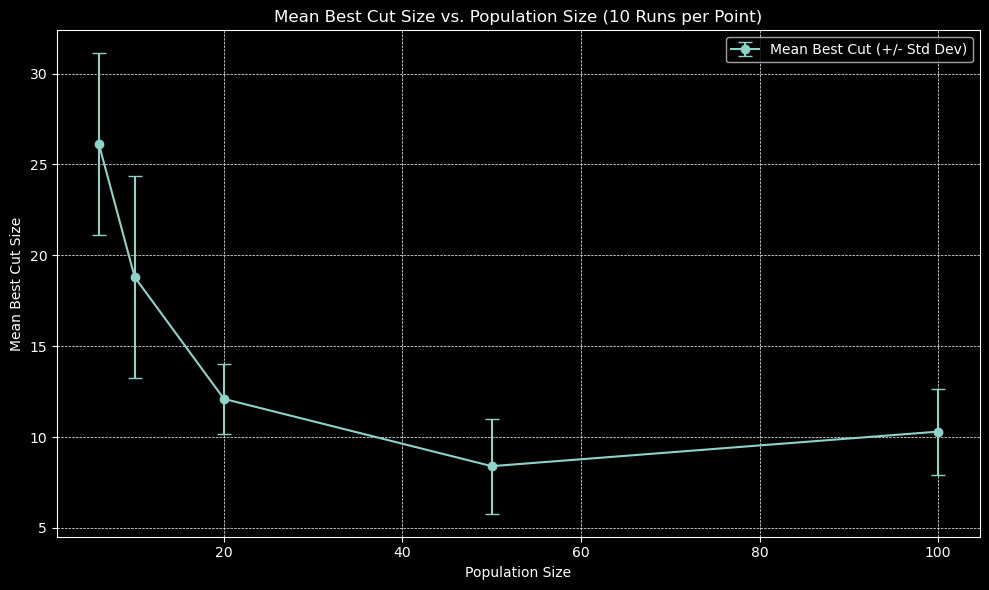

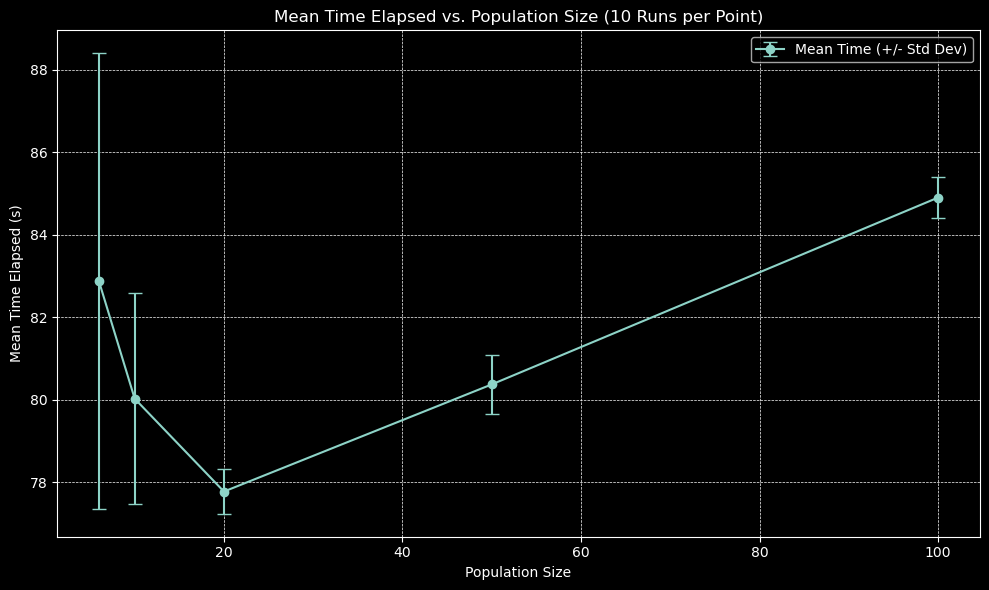

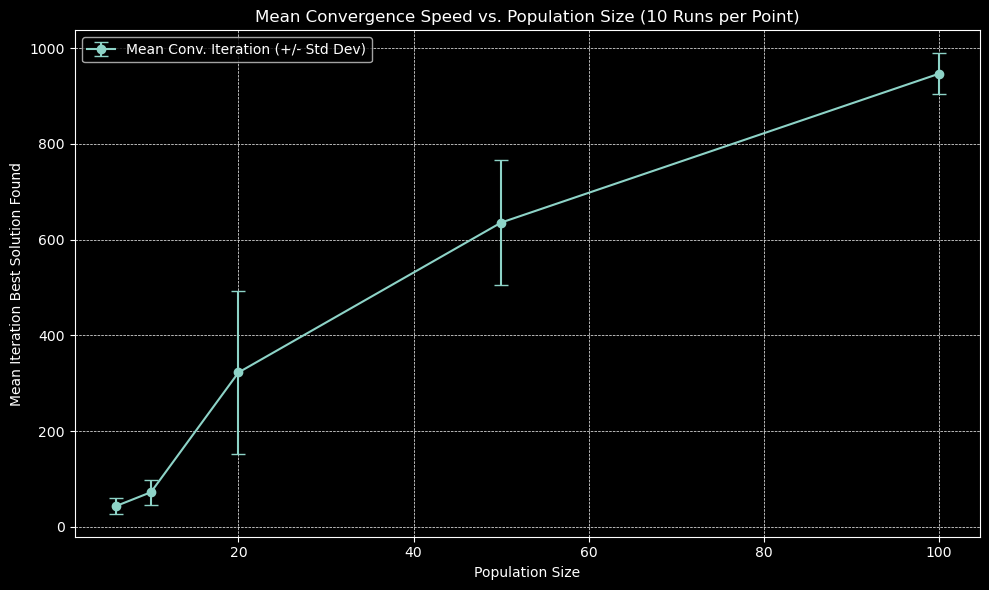

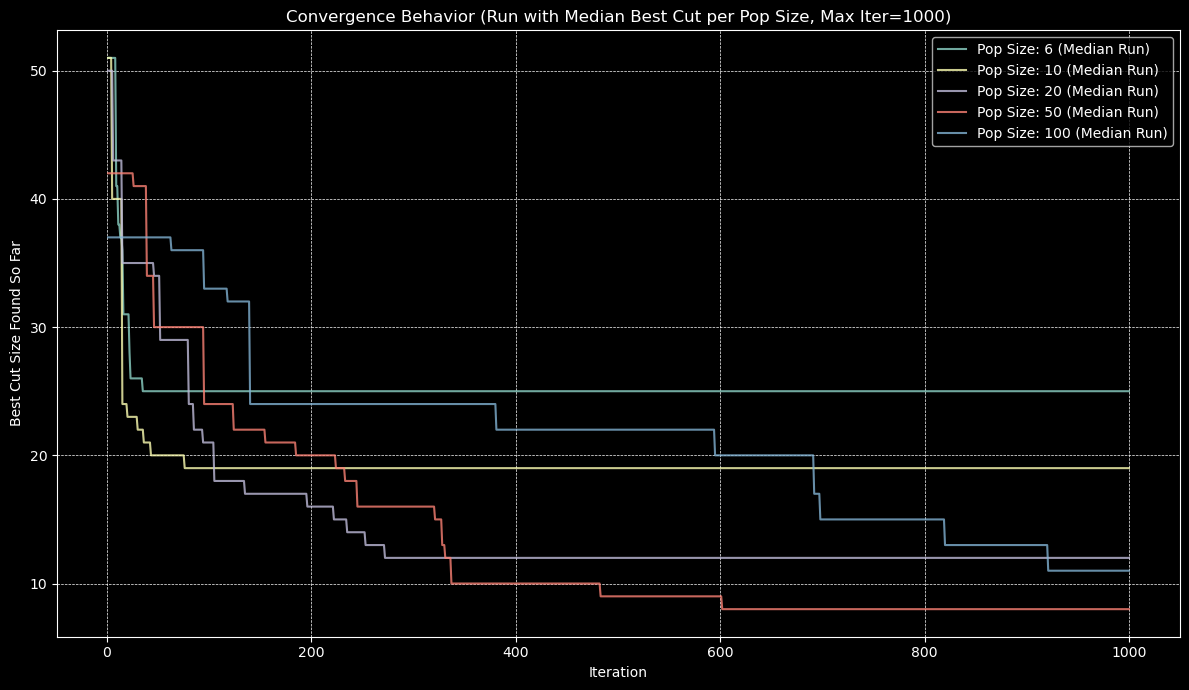

In [53]:

# Create DataFrame from the list of aggregated results
df_agg = pd.DataFrame(aggregated_results)

# Sort by population size for consistent plotting
print(f"data frame columns: {df_agg.columns}")
df_agg = df_agg.sort_values(by="pop_size").reset_index(drop=True)
print("\nAggregated Results DataFrame:")
# Display relevant columns
print(df_agg[[
    "pop_size", "num_runs", "mean_best_cut_size", "std_dev_best_cut_size", "min_best_cut_size", "max_best_cut_size",
    "mean_time_elapsed", "std_dev_time_elapsed", "mean_convergence_iteration"
]].round(2)) # Round for display

# Plot 1: Mean Best Cut Size vs. Population Size (with Error Bars)
plt.figure(figsize=(10, 6))
plt.errorbar(df_agg["pop_size"], df_agg["mean_best_cut_size"],
                yerr=df_agg["std_dev_best_cut_size"], # Std Dev across runs
                marker='o', capsize=5, linestyle='-', label='Mean Best Cut (+/- Std Dev)')
# Optional: Plot min/max range as well
# plt.fill_between(df_agg["pop_size"], df_agg["min_best_cut_size"], df_agg["max_best_cut_size"], alpha=0.2, label='Min/Max Range')

plt.xlabel("Population Size")
plt.ylabel("Mean Best Cut Size")
plt.title(f"Mean Best Cut Size vs. Population Size ({df_agg['num_runs'].iloc[0]} Runs per Point)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 2: Mean Time Elapsed vs. Population Size (with Error Bars)
plt.figure(figsize=(10, 6))
plt.errorbar(df_agg["pop_size"], df_agg["mean_time_elapsed"],
                yerr=df_agg["std_dev_time_elapsed"], # Std Dev across runs
                marker='o', capsize=5, linestyle='-', label='Mean Time (+/- Std Dev)')
plt.xlabel("Population Size")
plt.ylabel("Mean Time Elapsed (s)")
plt.title(f"Mean Time Elapsed vs. Population Size ({df_agg['num_runs'].iloc[0]} Runs per Point)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 3: Mean Convergence Iteration vs Population Size (with Error Bars)
plt.figure(figsize=(10, 6))
plt.errorbar(df_agg["pop_size"], df_agg["mean_convergence_iteration"],
                yerr=df_agg["std_dev_convergence_iteration"], # Std Dev across runs
                marker='o', capsize=5, linestyle='-', label='Mean Conv. Iteration (+/- Std Dev)')
plt.xlabel("Population Size")
plt.ylabel("Mean Iteration Best Solution Found")
plt.title(f"Mean Convergence Speed vs. Population Size ({df_agg['num_runs'].iloc[0]} Runs per Point)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Consider logarithmic scale if values vary widely or convergence is very fast
# plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot 4: Convergence Curves (from Median Run for each Pop Size)
plt.figure(figsize=(12, 7))
plot_success_p4 = False
for pop_size_key in sorted(convergence_logs_median_run.keys()):
    iter_df = convergence_logs_median_run[pop_size_key]
    # Check if DataFrame is valid and contains the necessary column
    if not iter_df.empty and 'best_cut_size_so_far' in iter_df.columns:
        plt.plot(iter_df.index, iter_df['best_cut_size_so_far'], label=f'Pop Size: {pop_size_key} (Median Run)', alpha=0.8)
        plot_success_p4 = True
    else:
        print(f"Warning: No valid convergence log found/plotted for Pop Size {pop_size_key}")

if plot_success_p4:
    plt.xlabel("Iteration")
    plt.ylabel("Best Cut Size Found So Far")
    plt.title(f"Convergence Behavior (Run with Median Best Cut per Pop Size, Max Iter={df_agg['max_iterations'].iloc[0]})")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # Optional: Log scale for axes if needed
    # plt.xscale('log')
    # plt.yscale('log')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Convergence Plot (Plot 4): No valid data could be plotted.")



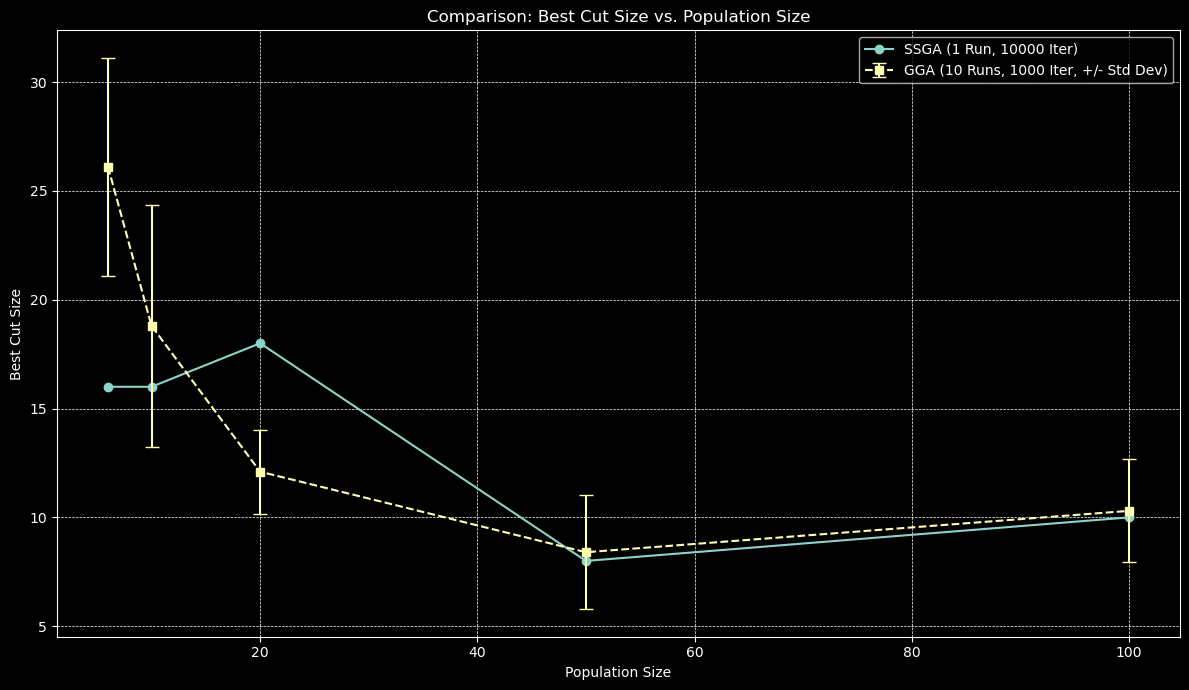

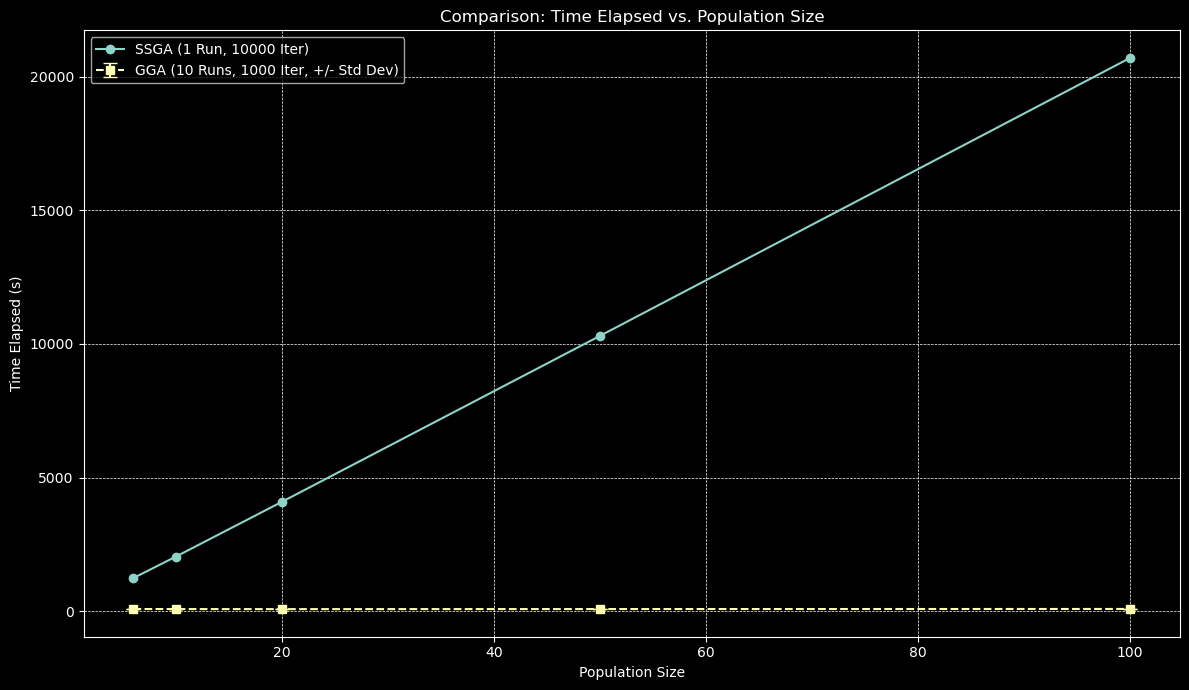

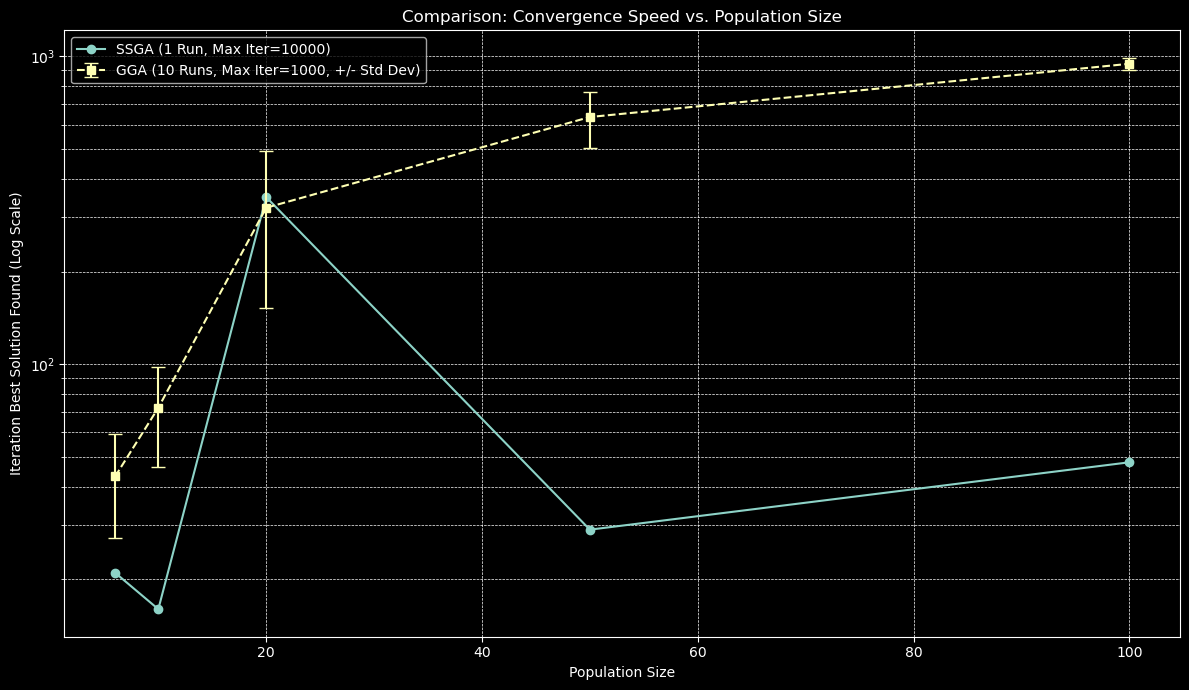


Plotting combined convergence curves for common pop sizes: [6, 10, 20, 50, 100]


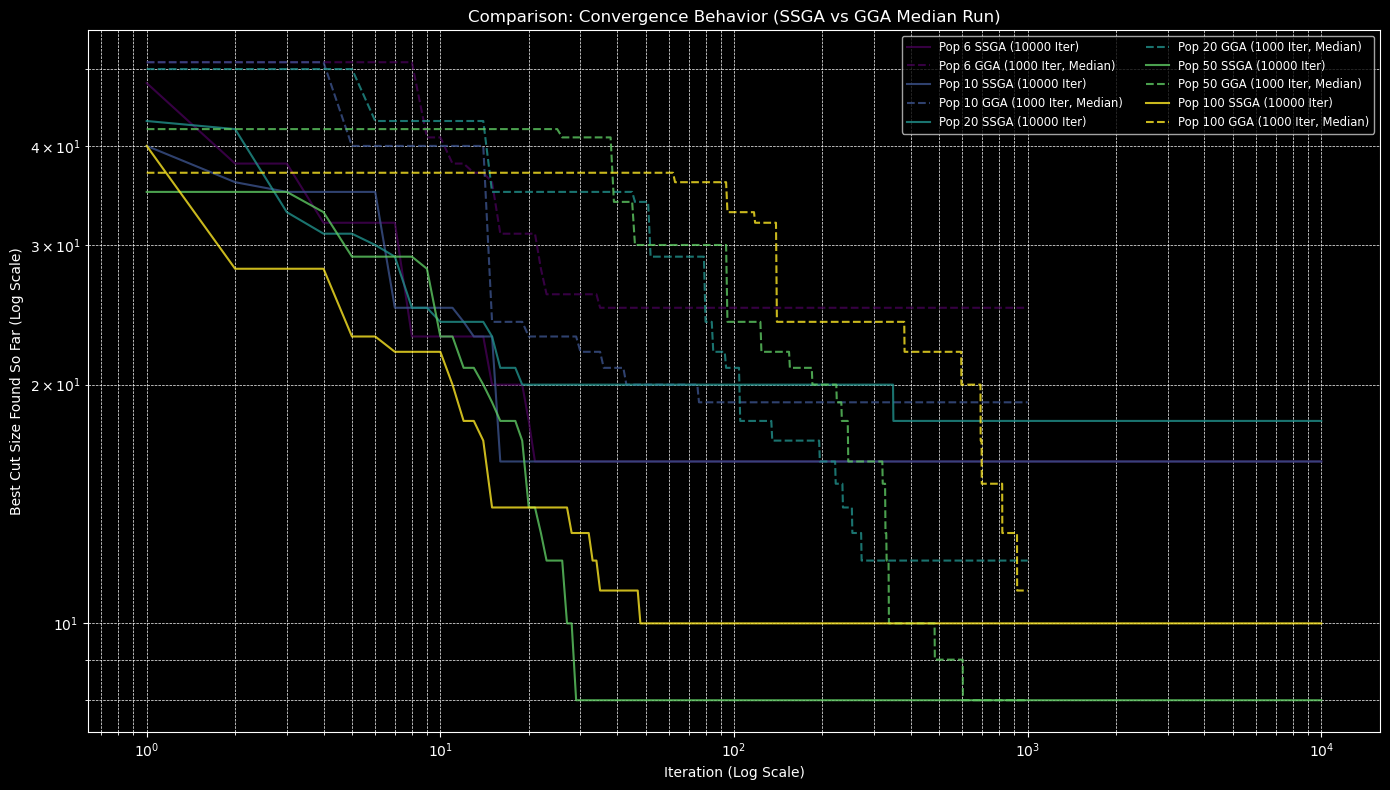


--- Combined Plotting Complete ---


In [ ]:
# Plot 1 Best Cut Size Comparison 
plt.figure(figsize=(12, 7))

# Plot SSGA
ssga_iters = df["max_iterations"].iloc[0] if not df.empty else 'N/A'
plt.plot(df["pop_size"], df["best_cut_size"], marker='o', linestyle='-',
            label=f'SSGA (1 Run, {ssga_iters} Iter)')

# Plot GGA 
gga_runs = df_agg["num_runs"].iloc[0] if not df_agg.empty else 'N/A'
gga_iters = df_agg["max_iterations"].iloc[0] if not df_agg.empty else 'N/A'
plt.errorbar(df_agg["pop_size"], df_agg["mean_best_cut_size"],
                yerr=df_agg["std_dev_best_cut_size"],
                marker='s', # Different marker
                capsize=5, linestyle='--', # Different linestyle
                label=f'GGA ({gga_runs} Runs, {gga_iters} Iter, +/- Std Dev)')

plt.xlabel("Population Size")
plt.ylabel("Best Cut Size")
plt.title("Comparison: Best Cut Size vs. Population Size")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 2 
plt.figure(figsize=(12, 7))

# Plot SSGA
plt.plot(df["pop_size"], df["time_elapsed"], marker='o', linestyle='-',
            label=f'SSGA (1 Run, {ssga_iters} Iter)')

# Plot GGA 
plt.errorbar(df_agg["pop_size"], df_agg["mean_time_elapsed"],
                yerr=df_agg["std_dev_time_elapsed"],
                marker='s', capsize=5, linestyle='--',
                label=f'GGA ({gga_runs} Runs, {gga_iters} Iter, +/- Std Dev)')

plt.xlabel("Population Size")
plt.ylabel("Time Elapsed (s)")
plt.title("Comparison: Time Elapsed vs. Population Size")
# plt.yscale('log')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot 3 
plt.figure(figsize=(12, 7))

# Plot SSGA
plt.plot(df["pop_size"], df["convergence_iteration"], marker='o', linestyle='-',
            label=f'SSGA (1 Run, Max Iter={ssga_iters})')

# Plot GGA 
plt.errorbar(df_agg["pop_size"], df_agg["mean_convergence_iteration"],
                yerr=df_agg["std_dev_convergence_iteration"],
                marker='s', capsize=5, linestyle='--',
                label=f'GGA ({gga_runs} Runs, Max Iter={gga_iters}, +/- Std Dev)')

plt.xlabel("Population Size")
plt.ylabel("Iteration Best Solution Found (Log Scale)") # Keep label consistent
plt.title("Comparison: Convergence Speed vs. Population Size")
plt.yscale('log') # Apply log scale as in your previous plots
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#Plot 4 Convergence 
# Check if both log dictionaries are available
if 'detailed_iteration_data' in locals() and 'convergence_logs_median_run' in locals():
    plt.figure(figsize=(14, 8))
    plot_success_p4c = False

    # Find common population sizes for which we have log data in both sets
    common_pop_sizes = sorted(list(set(detailed_iteration_data.keys()) & set(convergence_logs_median_run.keys())))
    print(f"\nPlotting combined convergence curves for common pop sizes: {common_pop_sizes}")

    # Define colors for different population sizes
    colors = plt.cm.viridis(np.linspace(0, 1, len(common_pop_sizes)))

    for i, pop_size_key in enumerate(common_pop_sizes):
        color = colors[i]
        label_prefix = f'Pop {pop_size_key}'

        # Plot SSGA log data (Solid Line)
        iter_df_ssga = detailed_iteration_data.get(pop_size_key)
        if iter_df_ssga is not None and not iter_df_ssga.empty and 'best_cut_size_so_far' in iter_df_ssga.columns:
                plt.plot(iter_df_ssga.index, iter_df_ssga['best_cut_size_so_far'],
                        label=f'{label_prefix} SSGA ({ssga_iters} Iter)',
                        alpha=0.8, color=color, linestyle='-') # Solid line
                plot_success_p4c = True
        else:
            print(f"  Warning: Missing/invalid SSGA log data for pop size {pop_size_key}")


        # Plot GGA log data (Median Run, Dashed Line)
        iter_df_gga = convergence_logs_median_run.get(pop_size_key)
        if iter_df_gga is not None and not iter_df_gga.empty and 'best_cut_size_so_far' in iter_df_gga.columns:
                plt.plot(iter_df_gga.index, iter_df_gga['best_cut_size_so_far'],
                        label=f'{label_prefix} GGA ({gga_iters} Iter, Median)',
                        alpha=0.8, color=color, linestyle='--') # Dashed line
                plot_success_p4c = True
        else:
                print(f"  Warning: Missing/invalid GGA log data for pop size {pop_size_key}")

    
    if plot_success_p4c:
        plt.xlabel("Iteration (Log Scale)")
        plt.ylabel("Best Cut Size Found So Far (Log Scale)")
        plt.title("Comparison: Convergence Behavior (SSGA vs GGA Median Run)")
        plt.xscale('log') # Use log scale for iterations
        plt.yscale('log') # Use log scale for cut size
        plt.legend(fontsize='small', ncol=2) # Adjust legend columns if many entries
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print("\nSkipping Combined Convergence Plot (Plot 4): No valid convergence data found for common population sizes.")
else:
    print("\nSkipping Combined Convergence Plot (Plot 4): Log data dictionaries ('detailed_iteration_data' or 'convergence_logs_median_run') not found.")

